# DataPower Latency Logs into Pandas #

This notebook describes how to read DataPower latency logs into
a Python [Pandas](http://pandas.pydata.org/) data frame.

## Convert Latency Log to CSV ##

Convert the latency log created by DataPower into a CSV file.
File names are hard-coded for the demo.

In [1]:
import re

In [2]:
reg = re.compile(r'\w\w\w (\w\w\w \d\d \d\d\d\d \d\d:\d\d:\d\d) \[0x80e00073\]\[latency\]\[info\] \w+\(([^)]+)\): tid\((\d+)\).+ Latency:\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+\[(https?://[^/]+)([^?]+)?(\?.+)?\]')

That was an insane regular expression to divide up a DataPower latency line into
individual fields we care about.  A raw latency line looks like this.

```
Wed Dec 02 2015 07:03:23 [0x80e00073][latency][info] mpgw(proxy-mpgw): tid(77904)[192.168.152.1] gtid(77904): Latency:   0 580   0  15  15  10   0 580 595 580 595 595 589 580  15 580 [http://192.168.152.24:8082/request3?t=563]
```

The following steps show how the regular expressions chops it up.

1. `\w\w\w (\w\w\w \d\d \d\d\d\d \d\d:\d\d:\d\d)` - This is the first
   grouping.  It makes the date (not including the week day) the first
   element.
2. `\[0x80e00073\]\[latency\]\[info\] \w+\(([^)]+)\)` - This skips a
   bunch of constants and captures the name of the MPGW.  It expects
   it to be between the matching parenthesis.
3. `: tid\((\d+)\)` - This captures the Transaction ID.
4. `.+ Latency:` - This makes sure we're matching a Latency record.
   The constant in Step 2 probably did this already.  The space before
   the capital `L` makes sure this is not an extended latency record.
5. `\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)` - These are the 16 numbers
   separated by spaces.
6. `\s+\[(https?://[^/]+)` - this matches the host and port.
7. `([^?]+)?` - this matches the optional URI after the host.
8. `(\?.+)?` - this matches an optional parameter list.
9. `\]` - The expression should end with a square bracket.

There are usually lots of other lines that are not latency entries.  So the regex
will pluck out only the latency log entries and group the fields for us.  Our raw
log is `sample5.log`.

In [3]:
dplog  = open('sample5.log', 'r')
output = open('sample5.csv', 'w')
output.write('Time,ProxyName,TxnID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,url,uri,q\n')
lines_processed = 0

In [4]:
line = dplog.readline()
line

'Tue Dec 01 2015 21:34:26 [0x80e00073][latency][info] mpgw(proxy-mpgw): tid(84483)[192.168.152.1] gtid(84483): Latency:   0 450   0  18  18  13   0 450 462 450 462 462 457 450  18 450 [http://192.168.152.24:8082/request5?t=429]\r\n'

Check if the line matches our regex.

In [5]:
fields = reg.match(line)
fields

When we get an object reference like this (not a `None`), that's a match.
Let's see what our grouping looks like given the input line above.

In [6]:
fields.groups()

('Dec 01 2015 21:34:26',
 'proxy-mpgw',
 '84483',
 '0',
 '450',
 '0',
 '18',
 '18',
 '13',
 '0',
 '450',
 '462',
 '450',
 '462',
 '462',
 '457',
 '450',
 '18',
 '450',
 'http://192.168.152.24:8082',
 '/request5',
 '?t=429')

This all looks good.  So let's create a comma-separated line from this
and send it to the output file.

In [7]:
csvline = ','.join(fields.groups())
csvline

'Dec 01 2015 21:34:26,proxy-mpgw,84483,0,450,0,18,18,13,0,450,462,450,462,462,457,450,18,450,http://192.168.152.24:8082,/request5,?t=429'

In [8]:
output.write(csvline + '\n')
lines_processed += 1

Now do this for the rest of the file.

In [9]:
for line in dplog:
    fields = reg.match(line)
    if fields != None:
        csvline = ','.join(fields.groups())
        output.write(csvline + '\n')
        lines_processed += 1

print("Processed {0} lines.".format(lines_processed))

Processed 150 lines.


In [10]:
dplog.close()
output.close()

In [13]:
!head -n 5 sample5.csv

Time,ProxyName,TxnID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,url,uri,q
Dec 01 2015 21:34:26,proxy-mpgw,84483,0,450,0,18,18,13,0,450,462,450,462,462,457,450,18,450,http://192.168.152.24:8082,/request5,?t=429
Dec 01 2015 21:34:28,proxy-mpgw,89186,0,246,0,14,14,9,0,246,259,246,259,259,254,246,14,246,http://192.168.152.24:8082,/request1,?t=229
Dec 01 2015 21:34:28,proxy-mpgw,89170,0,1887,0,13,13,7,0,1887,1900,1887,1900,1900,1896,1887,13,1887,http://192.168.152.24:8082,/request4,?t=1871
Dec 01 2015 21:34:28,proxy-mpgw,84515,0,1988,0,14,14,8,0,1988,2000,1988,2000,2001,1996,1988,14,1988,http://192.168.152.24:8082,/request1,?t=1971


From here we may switch to R or continue with Pandas.
Since this is an IPython notebook, we'll go with Pandas.

## Creating Pandas Data Frames from CSV ##


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Create a Pandas data frame from the CSV and indicate that the `Time` field
is to be parsed as a Numpy `datetime64`.

In [2]:
df1 = pd.read_csv('sample5.csv', parse_dates=['Time'])
df1.head()

,Time,ProxyName,TxnID,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,url,uri,q
0,2015-12-01 21:34:26,proxy-mpgw,84483,0,450,0,18,18,13,0,...,450,462,462,457,450,18,450,http://192.168.152.24:8082,/request5,?t=429
1,2015-12-01 21:34:28,proxy-mpgw,89186,0,246,0,14,14,9,0,...,246,259,259,254,246,14,246,http://192.168.152.24:8082,/request1,?t=229
2,2015-12-01 21:34:28,proxy-mpgw,89170,0,1887,0,13,13,7,0,...,1887,1900,1900,1896,1887,13,1887,http://192.168.152.24:8082,/request4,?t=1871
3,2015-12-01 21:34:28,proxy-mpgw,84515,0,1988,0,14,14,8,0,...,1988,2000,2001,1996,1988,14,1988,http://192.168.152.24:8082,/request1,?t=1971
4,2015-12-01 21:34:29,proxy-mpgw,89202,0,703,0,15,15,9,0,...,703,713,714,710,703,15,703,http://192.168.152.24:8082,/request4,?t=687


The first issue to address is what to do with 16 columns of times that have
[non-intuitive interpretations](https://www.ibm.com/developerworks/community/blogs/HermannSW/entry/latency_messages_in_datapower_appliance21?lang=en).
We'll take the simple approach of taking the maximum of all 16 columns
for each row and assigning it to a new columns generically named `Latency`.

In [3]:
df1['Latency'] = df1.loc[:,'1':'16'].apply(max, axis=1)

The `loc` method indexes the data frame.  The first element specifies rows.
The `:` means all rows.  The second element specifies columns.  The expression
'1':'16' means columns starting with the column named `1` to the column named
`16`.  These are string values (columns names), not integers.

The result is a 16-column data frame with all the rows of the original data
frame.  The `apply` function applies a function to the data frame.  We chose
to apply the `max` function.  By default, it is applied across rows
(`axis=0`).  We override this to apply the max across columns, `axis=1`.

Let's create a new data frame that abandons the 16 partial values and only
includes columns we care about for now.

In [4]:
df2 = df1.loc[:,['Time', 'Latency', 'TxnID', 'uri']]
df2.head()

,Time,Latency,TxnID,uri
0,2015-12-01 21:34:26,462,84483,/request5
1,2015-12-01 21:34:28,259,89186,/request1
2,2015-12-01 21:34:28,1900,89170,/request4
3,2015-12-01 21:34:28,2001,84515,/request1
4,2015-12-01 21:34:29,714,89202,/request4


Now we can knock ourselves out with all kinds of graphs at our disposal.
Here is a set of box plots grouped by `uri`.

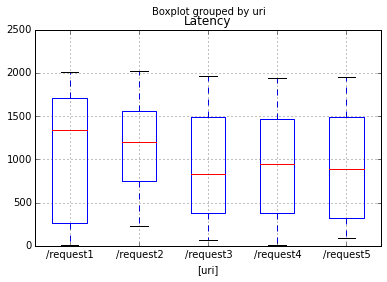

In [5]:
df2.boxplot(column=['Latency'], by=['uri'])

The response times for the different URI values are similar because each URI sampled the same statistical distribution for the backend times.